This is an example to use the py_ppo and the gee_subset in a notebook on CRIB!

- py_ppo: https://github.com/phenology/phenologyX

- gee_subset: https://github.com/bluegreen-labs/gee_subset

In [1]:
import ee
try:
  ee.Initialize()
  print('Google Earth Engine has initialized successfully!')
except ee.EEException as e:
  print('Google Earth Engine has failed to initialize!')
except:
    print("Unexpected error:", sys.exc_info()[0])
    raise

Google Earth Engine has initialized successfully!


In [2]:
import matplotlib.pyplot as plt
from cartopy import crs
from py_ppo import download

import os
import glob
import pandas as pd
from gee_subset import gee_subset
import geopandas as gpd
import tempfile

In [3]:
# input and output path
path = os.getcwd()

In [4]:
def flowers_present(df):
    return df.termID.str.contains("obo:PPO_0002330")


def true_leaves_present(df):
    return df.termID.str.contains("obo:PPO_0002313")


def senescing_true_leaves_present(df):
    return df.termID.str.contains("obo:PPO_0002317")


def leafing_out_date(df):
    condition = true_leaves_present and ~senescing_true_leaves_present(df)
    unique_idx = ['latitude', 'longitude', 'year']
    event = df.where(condition).groupby(unique_idx).dayOfYear.min()
    return event.reset_index()


In [5]:
pnts = download(
    genus="Syringa",
    source="PEP725",
    year="[2018 TO 2018]",
    latitude="[40 TO 70]",
    longitude="[-10 TO 40]",
    termID= "obo:PPO_0002313",
    explode=False,
    limit=10,
    )

Sending request: https://biscicol.org/api/v3/download/_search?limit=10&q=genus:Syringa+AND+source:PEP725+AND+year:[2018 TO 2018]+AND+latitude:[40 TO 70]+AND+longitude:[-10 TO 40]+AND+termID:"obo:PPO_0002313"

Retrieved 5 of 5 total possible results.
Please note the additional download and license information in df.attrs


In [6]:
pnts.head()

,dayOfYear,year,genus,specificEpithet,latitude,longitude,termID,source,eventId
0,116,2018,Syringa,vulgaris,50.4151,30.5573,"obo:PPO_0002014,obo:PPO_0002015,obo:PPO_000201...",PEP725,urn:phenologicalObservingProcess/5d967a9e-6f00...
1,113,2018,Syringa,josikaea J.Jacq. ex Rchb.,50.4151,30.5573,"obo:PPO_0002014,obo:PPO_0002016,obo:PPO_000201...",PEP725,urn:phenologicalObservingProcess/9f1a8ae9-90b8...
2,130,2018,Syringa,vulgaris,42.8333,19.5167,"obo:PPO_0002014,obo:PPO_0002017,obo:PPO_000201...",PEP725,urn:phenologicalObservingProcess/77d8c08a-b916...
3,115,2018,Syringa,josikaea J.Jacq. ex Rchb.,50.4151,30.5573,"obo:PPO_0002315,obo:PPO_0002316,obo:PPO_000231...",PEP725,urn:phenologicalObservingProcess/9566c265-dcdf...
4,114,2018,Syringa,vulgaris,50.4151,30.5573,"obo:PPO_0002000,obo:PPO_0002024,obo:PPO_000201...",PEP725,urn:phenologicalObservingProcess/8b097087-d971...


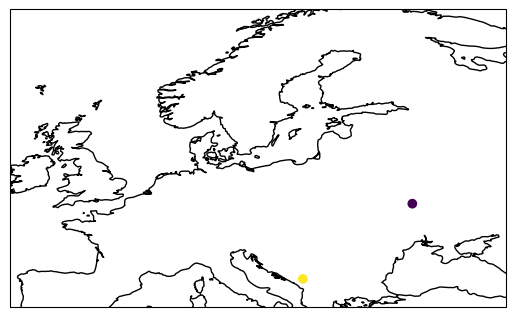

In [7]:
event = leafing_out_date(pnts)
fig = plt.figure()
ax = fig.add_subplot(projection=crs.PlateCarree())
ax.coastlines()
ax.set_xlim(-10, 40)
ax.set_ylim(40, 70)
ax.scatter(event.longitude, event.latitude, c=event.dayOfYear)
fig.savefig('test_image', bbox_inches='tight')

In [8]:
pnts['pnt_id'] = range(1, len(pnts) + 1)
pnts.head()

,dayOfYear,year,genus,specificEpithet,latitude,longitude,termID,source,eventId,pnt_id
0,116,2018,Syringa,vulgaris,50.4151,30.5573,"obo:PPO_0002014,obo:PPO_0002015,obo:PPO_000201...",PEP725,urn:phenologicalObservingProcess/5d967a9e-6f00...,1
1,113,2018,Syringa,josikaea J.Jacq. ex Rchb.,50.4151,30.5573,"obo:PPO_0002014,obo:PPO_0002016,obo:PPO_000201...",PEP725,urn:phenologicalObservingProcess/9f1a8ae9-90b8...,2
2,130,2018,Syringa,vulgaris,42.8333,19.5167,"obo:PPO_0002014,obo:PPO_0002017,obo:PPO_000201...",PEP725,urn:phenologicalObservingProcess/77d8c08a-b916...,3
3,115,2018,Syringa,josikaea J.Jacq. ex Rchb.,50.4151,30.5573,"obo:PPO_0002315,obo:PPO_0002316,obo:PPO_000231...",PEP725,urn:phenologicalObservingProcess/9566c265-dcdf...,4
4,114,2018,Syringa,vulgaris,50.4151,30.5573,"obo:PPO_0002000,obo:PPO_0002024,obo:PPO_000201...",PEP725,urn:phenologicalObservingProcess/8b097087-d971...,5


Now let's get some Landsat 8 data!

In [9]:
# Landsat 8 Tier 1 surface reflectance

# create a index list to iterate over
siteSet = list(range(0, len(pnts), 1))

with tempfile.TemporaryDirectory() as tmpdirname:
    for i in siteSet:
        df1 = gee_subset.gee_subset(product = "LANDSAT/LC08/C01/T1_SR", bands = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B10","B11", "sr_aerosol", "pixel_qa", "radsat_qa"], 
                                    start_date = str(pnts.iloc[0, 1])+"-01-01", 
                                    end_date = str(pnts.iloc[0, 1])+"-12-31", 
                                    latitude = pnts.iloc[i, 4], 
                                    longitude = pnts.iloc[i ,5], scale = 30)

        sid = str(pnts.iloc[i, -1]) 
        df1["SiteID"] = sid
        df1.to_csv(tmpdirname + "/site_" + str(pnts.iloc[i, -1]) + ".csv")
    
    # list all CSV files in working directory.
    os.chdir(tmpdirname)
    all_filenames = [i for i in glob.glob('*.csv')]
    print(all_filenames)
    
    # combine all files in the list
    combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
    
    # export to csv
    combined_csv.to_csv( path + "/combined_csv.csv", index=False, encoding='utf-8-sig')

['site_5.csv', 'site_2.csv', 'site_1.csv', 'site_4.csv', 'site_3.csv']


In [10]:
# change the working directory
os.chdir(path)
# read the combined csv
combined_csv = pd.read_csv('combined_csv.csv')
combined_csv.shape

(147, 19)

In [11]:
# Create new date column with a new format
combined_csv['date_adjusted'] = combined_csv['date'].str[:10]
combined_csv['date_adjusted'] = pd.to_datetime(combined_csv['date_adjusted'])
combined_csv['date_adjusted'] = combined_csv['date_adjusted'].dt.strftime('%Y/%m/%d')
combined_csv.head()

,Unnamed: 0,id,longitude,latitude,date,B1,B2,B3,B4,B5,B6,B7,B10,B11,sr_aerosol,pixel_qa,radsat_qa,product,SiteID,date_adjusted
0,0,LC08_181025_20180108,30.557317,50.415026,2018-01-08 08:49:17.740000000,430,452,473,475,923,1067,852,2722,2725,100,322,0,LANDSAT/LC08/C01/T1_SR,5,2018/01/08
1,1,LC08_181025_20180124,30.557317,50.415026,2018-01-24 08:49:09.349999872,2827,2833,2868,2890,3122,396,548,2641,2643,164,336,0,LANDSAT/LC08/C01/T1_SR,5,2018/01/24
2,2,LC08_181025_20180225,30.557317,50.415026,2018-02-25 08:48:55.509999872,5194,5240,5016,5164,5084,655,777,2622,2624,196,336,0,LANDSAT/LC08/C01/T1_SR,5,2018/02/25
3,3,LC08_181025_20180414,30.557317,50.415026,2018-04-14 08:48:30.880000000,911,968,976,1050,1673,2105,1821,2922,2908,96,322,0,LANDSAT/LC08/C01/T1_SR,5,2018/04/14
4,4,LC08_181025_20180430,30.557317,50.415026,2018-04-30 08:48:21.927000064,540,593,881,782,2656,1731,1194,2999,2984,96,322,0,LANDSAT/LC08/C01/T1_SR,5,2018/04/30


In [12]:
# filter cloudy low quality pixels using pixel_qa
# https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/landsat-in-Python/remove-clouds-from-landsat-data/
# https://www.usgs.gov/core-science-systems/nli/landsat/landsat-collection-1-level-1-quality-assessment-band?qt-science_support_page_related_con=0#qt-science_support_page_related_con 

# # cloud_shadow + cloud + high_cloud_confidence
# all_masked_values = [328,392,840,904,1350,352,368,416,432,480,864,880,928,944,992,480,992]
# SatData = combined_csv.loc[~combined_csv['pixel_qa'].isin(all_masked_values)]

valid_values = [322, 386, 834, 898, 1346, 324, 388, 836, 900, 1348]
SatData = combined_csv.loc[combined_csv['pixel_qa'].isin(valid_values)]
print(SatData.shape)
SatData.head()

(82, 20)


,Unnamed: 0,id,longitude,latitude,date,B1,B2,B3,B4,B5,B6,B7,B10,B11,sr_aerosol,pixel_qa,radsat_qa,product,SiteID,date_adjusted
0,0,LC08_181025_20180108,30.557317,50.415026,2018-01-08 08:49:17.740000000,430,452,473,475,923,1067,852,2722,2725,100,322,0,LANDSAT/LC08/C01/T1_SR,5,2018/01/08
3,3,LC08_181025_20180414,30.557317,50.415026,2018-04-14 08:48:30.880000000,911,968,976,1050,1673,2105,1821,2922,2908,96,322,0,LANDSAT/LC08/C01/T1_SR,5,2018/04/14
4,4,LC08_181025_20180430,30.557317,50.415026,2018-04-30 08:48:21.927000064,540,593,881,782,2656,1731,1194,2999,2984,96,322,0,LANDSAT/LC08/C01/T1_SR,5,2018/04/30
6,6,LC08_181025_20180601,30.557317,50.415026,2018-06-01 08:47:58.620000000,648,717,927,925,2877,1930,1300,2992,2982,96,322,0,LANDSAT/LC08/C01/T1_SR,5,2018/06/01
10,10,LC08_181025_20180804,30.557317,50.415026,2018-08-04 08:48:31.150000128,545,648,856,862,2415,1624,1038,3010,2976,96,322,0,LANDSAT/LC08/C01/T1_SR,5,2018/08/04


Now let's check the NDVI time series in one of the sites.

In [13]:
site1 = SatData.loc[SatData['SiteID'] == 1]

In [14]:
ndvi = (site1["B5"]-site1["B7"])/(site1["B5"]+site1["B7"])

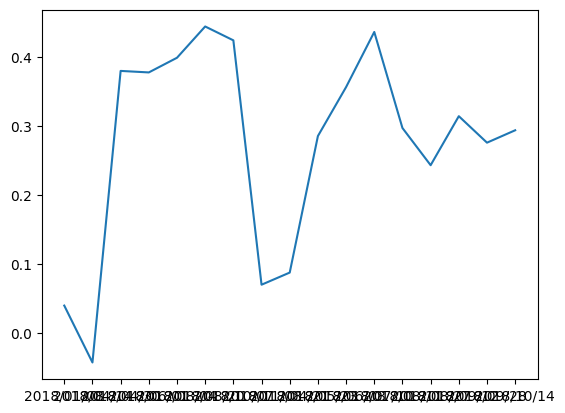

In [15]:
plt.plot(site1["date_adjusted"], ndvi)